In [ ]:
# pip install streamlit pyngrok


In [ ]:
# pip install streamlit

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth', None)
import os
import re
import torch
import torch.nn as nn
import torch.nn.functional as F  # Import F for activation functions
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, roc_curve, roc_auc_score,
                             precision_recall_curve, average_precision_score,
                             classification_report)
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings("ignore")

# Set random seeds for reproducibility
np.random.seed(1)
torch.manual_seed(1)


In [ ]:
# Load data
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')

# Shuffle data
train = train.sample(frac=1, random_state=1).reset_index(drop=True)
test = test.sample(frac=1, random_state=1).reset_index(drop=True)

# Drop unnecessary columns
train.drop(['keyword', 'location'], axis=1, inplace=True)
test.drop(['keyword', 'location'], axis=1, inplace=True)


In [ ]:
# Clean text function
def clean_text(text):
    # Remove unknown characters (emojis, etc.)
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)

    # Remove URLs
    url = re.compile(r'https?://\S+|www\.\S+')
    text = url.sub(r'', text)

    # Remove hashtags and mentions
    text = text.replace('#', ' ')
    text = text.replace('@', ' ')

    # Remove special characters
    symbols = re.compile(r'[^A-Za-z0-9 ]')
    text = symbols.sub(r'', text)

    # Convert to lowercase
    text = text.lower()

    return text

# Apply text cleaning
train['text'] = train['text'].apply(lambda x: clean_text(x))
test['text'] = test['text'].apply(lambda x: clean_text(x))


In [ ]:
# Load GloVe embeddings
embeddings_index = {}
with open('/content/glove.6B.50d.txt', 'r', encoding='utf8') as f:
    for line in f:
        values = line.strip().split()
        word = values[0]
        coefs = np.array(values[1:], dtype='float32')
        embeddings_index[word] = coefs
print(f'Found {len(embeddings_index)} word vectors.')


Found 169500 word vectors.


In [ ]:
# Prepare embeddings and word indices
word2idx = {}
new_embedding_index = {}

# Build vocabulary and embedding matrix
index = 1  # Start indexing from 1
for dataset in [train, test]:
    for x in dataset['text']:
        words = x.split()
        for word in words:
            if word not in word2idx:
                word2idx[word] = index
                if word in embeddings_index:
                    new_embedding_index[index] = embeddings_index[word]
                else:
                    new_embedding_index[index] = np.random.normal(scale=0.6, size=(50,)).astype(np.float32)
                index += 1

# Add zero vector for padding index
new_embedding_index[0] = np.zeros(50, dtype=np.float32)


In [ ]:
# Save word2idx for later use
with open('word2idx.pkl', 'wb') as f:
    pickle.dump(word2idx, f)


In [ ]:
# Convert text to index sequences
def text_to_sequence(text_list, word2idx):
    sequences = []
    for text in text_list:
        words = text.split()
        seq = [word2idx.get(word, 0) for word in words]
        sequences.append(seq)
    return sequences

train_sequences = text_to_sequence(train['text'], word2idx)
test_sequences = text_to_sequence(test['text'], word2idx)


In [ ]:
# Padding sequences
def pad_sequences(sequences, maxlen):
    padded_sequences = np.zeros((len(sequences), maxlen), dtype=int)
    for i, seq in enumerate(sequences):
        if len(seq) > maxlen:
            padded_sequences[i] = np.array(seq[:maxlen])
        else:
            padded_sequences[i, -len(seq):] = np.array(seq)
    return padded_sequences

max_len = 55  # Based on max length observed
train_padded = pad_sequences(train_sequences, maxlen=max_len)
test_padded = pad_sequences(test_sequences, maxlen=max_len)


In [ ]:
# Prepare target variable
train_labels = train['target'].values

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_padded, train_labels, test_size=0.2, random_state=1)

# Create DataLoaders
batch_size = 64

# Convert to PyTorch tensors
train_data = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
valid_data = TensorDataset(torch.from_numpy(X_val), torch.from_numpy(y_val))

# DataLoaders
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=False, batch_size=batch_size)


In [ ]:
# Prepare embedding weights matrix
num_embeddings = len(new_embedding_index)
embedding_dim = 50
weights_matrix = np.zeros((num_embeddings, embedding_dim), dtype=np.float32)
for idx, vec in new_embedding_index.items():
    weights_matrix[idx] = vec
weights_matrix = torch.tensor(weights_matrix)


In [ ]:
class BiLSTM(nn.Module):
    def __init__(self, weights_matrix, output_size, hidden_dim, hidden_dim2, n_layers, drop_prob=0.5):
        super(BiLSTM, self).__init__()

        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim

        # Embedding layer
        num_embeddings, embedding_dim = weights_matrix.size()
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        self.embedding.weight.data.copy_(weights_matrix)
        self.embedding.weight.requires_grad = False  # Freeze embedding layer

        # BiLSTM layer
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=drop_prob, bidirectional=True, batch_first=True)

        # Dropout layer
        self.dropout = nn.Dropout(0.3)

        # Fully connected layers
        self.fc1 = nn.Linear(hidden_dim * 2, hidden_dim2)
        self.fc2 = nn.Linear(hidden_dim2, output_size)

        # Activation function
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, hidden):
        batch_size = x.size(0)

        # Embedding
        embeds = self.embedding(x)

        # LSTM
        lstm_out, hidden = self.lstm(embeds, hidden)

        # Stack up LSTM outputs
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim * 2)

        # Dropout and fully connected layers
        out = self.dropout(lstm_out)
        out = self.fc1(out)
        out = F.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)

        # Sigmoid activation
        sig_out = self.sigmoid(out)

        # Reshape to batch_size first
        sig_out = sig_out.view(batch_size, -1)
        sig_out = sig_out[:, -1]  # Get last batch of labels

        return sig_out, hidden

    def init_hidden(self, batch_size, train_on_gpu=False):
        weight = next(self.parameters()).data

        layers = self.n_layers * 2  # Multiply by 2 for bidirectionality
        if train_on_gpu:
            hidden = (weight.new(layers, batch_size, self.hidden_dim).zero_().cuda(),
                      weight.new(layers, batch_size, self.hidden_dim).zero_().cuda())
        else:
            hidden = (weight.new(layers, batch_size, self.hidden_dim).zero_(),
                      weight.new(layers, batch_size, self.hidden_dim).zero_())
        return hidden


In [ ]:
# Instantiate the model
output_size = 1
hidden_dim = 128
hidden_dim2 = 64
n_layers = 2

net = BiLSTM(weights_matrix, output_size, hidden_dim, hidden_dim2, n_layers)
print(net)

# Check if GPU is available
train_on_gpu = torch.cuda.is_available()
if train_on_gpu:
    net.cuda()

# Loss and optimization functions
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)


BiLSTM(
  (embedding): Embedding(22652, 50)
  (lstm): LSTM(50, 128, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=256, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [ ]:
# Training the model
epochs = 500  # You can increase this for better performance
clip = 5  # Gradient clipping
valid_loss_min = np.Inf  # Track change in validation loss

train_losses_epoch = []
val_losses_epoch = []

net.train()
for epoch in range(epochs):
    train_losses = []
    for inputs, labels in train_loader:
        # Move data to GPU if available
        if train_on_gpu:
            inputs, labels = inputs.cuda(), labels.cuda()
        else:
            inputs, labels = inputs, labels

        # Initialize hidden state based on actual batch size
        h = net.init_hidden(inputs.size(0), train_on_gpu)

        # Create new variables for hidden state
        h = tuple([each.data for each in h])

        net.zero_grad()

        # Forward pass
        outputs, h = net(inputs, h)
        loss = criterion(outputs.squeeze(), labels.float())
        loss.backward()

        # Gradient clipping
        nn.utils.clip_grad_norm_(net.parameters(), clip)

        optimizer.step()
        train_losses.append(loss.item())

    train_losses_epoch.append(np.mean(train_losses))

    # Validation
    val_losses = []
    net.eval()
    y_preds = []
    y_true = []
    y_probs = []
    with torch.no_grad():
        for inputs, labels in valid_loader:
            # Move data to GPU if available
            if train_on_gpu:
                inputs, labels = inputs.cuda(), labels.cuda()
            else:
                inputs, labels = inputs, labels

            # Initialize hidden state based on actual batch size
            val_h = net.init_hidden(inputs.size(0), train_on_gpu)

            # Create new variables for hidden state
            val_h = tuple([each.data for each in val_h])

            outputs, val_h = net(inputs, val_h)
            val_loss = criterion(outputs.squeeze(), labels.float())
            val_losses.append(val_loss.item())

            # Save predictions for evaluation metrics
            probs = outputs.squeeze().detach().cpu().numpy()
            preds = torch.round(outputs.squeeze())
            y_probs.extend(probs)
            y_preds.extend(preds.detach().cpu().numpy())
            y_true.extend(labels.detach().cpu().numpy())

    val_losses_epoch.append(np.mean(val_losses))

    net.train()

    print(f"Epoch: {epoch+1}/{epochs}...",
          f"Train Loss: {np.mean(train_losses):.6f}...",
          f"Val Loss: {np.mean(val_losses):.6f}...")

    # Save model if validation loss has decreased
    if np.mean(val_losses) <= valid_loss_min:
        torch.save(net.state_dict(), 'state_dict.pt')
        valid_loss_min = np.mean(val_losses)


Epoch: 1/500... Train Loss: 0.538091... Val Loss: 0.475925...
Epoch: 2/500... Train Loss: 0.460440... Val Loss: 0.455001...
Epoch: 3/500... Train Loss: 0.439144... Val Loss: 0.445394...
Epoch: 4/500... Train Loss: 0.436420... Val Loss: 0.438199...
Epoch: 5/500... Train Loss: 0.415481... Val Loss: 0.451574...
Epoch: 6/500... Train Loss: 0.405174... Val Loss: 0.450916...
Epoch: 7/500... Train Loss: 0.397085... Val Loss: 0.457545...
Epoch: 8/500... Train Loss: 0.385586... Val Loss: 0.457612...
Epoch: 9/500... Train Loss: 0.366098... Val Loss: 0.467326...
Epoch: 10/500... Train Loss: 0.352446... Val Loss: 0.490738...
Epoch: 11/500... Train Loss: 0.344960... Val Loss: 0.469121...
Epoch: 12/500... Train Loss: 0.317675... Val Loss: 0.532961...
Epoch: 13/500... Train Loss: 0.314310... Val Loss: 0.525323...
Epoch: 14/500... Train Loss: 0.287290... Val Loss: 0.587929...
Epoch: 15/500... Train Loss: 0.274995... Val Loss: 0.584338...
Epoch: 16/500... Train Loss: 0.256821... Val Loss: 0.599579...
E

In [ ]:
# Load the best model
net.load_state_dict(torch.load('state_dict.pt'))

# Evaluate on validation set
net.eval()
y_preds = []
y_true = []
y_probs = []
with torch.no_grad():
    for inputs, labels in valid_loader:
        # Move data to GPU if available
        if train_on_gpu:
            inputs, labels = inputs.cuda(), labels.cuda()
        else:
            inputs, labels = inputs, labels

        # Initialize hidden state based on actual batch size
        val_h = net.init_hidden(inputs.size(0), train_on_gpu)
        val_h = tuple([each.data for each in val_h])

        outputs, val_h = net(inputs, val_h)

        # Save predictions for evaluation metrics
        probs = outputs.squeeze().detach().cpu().numpy()
        preds = torch.round(outputs.squeeze())
        y_probs.extend(probs)
        y_preds.extend(preds.detach().cpu().numpy())
        y_true.extend(labels.detach().cpu().numpy())

# Calculate evaluation metrics on validation set
accuracy = accuracy_score(y_true, y_preds)
precision = precision_score(y_true, y_preds)
recall = recall_score(y_true, y_preds)
f1 = f1_score(y_true, y_preds)
confusion = confusion_matrix(y_true, y_preds)

print("\nEvaluation Metrics on Validation Set:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall (Sensitivity): {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print("Confusion Matrix:")
print(confusion)



Evaluation Metrics on Validation Set:
Accuracy: 0.8102
Precision: 0.8257
Recall (Sensitivity): 0.6852
F1-Score: 0.7489
Confusion Matrix:
[[803  91]
 [198 431]]


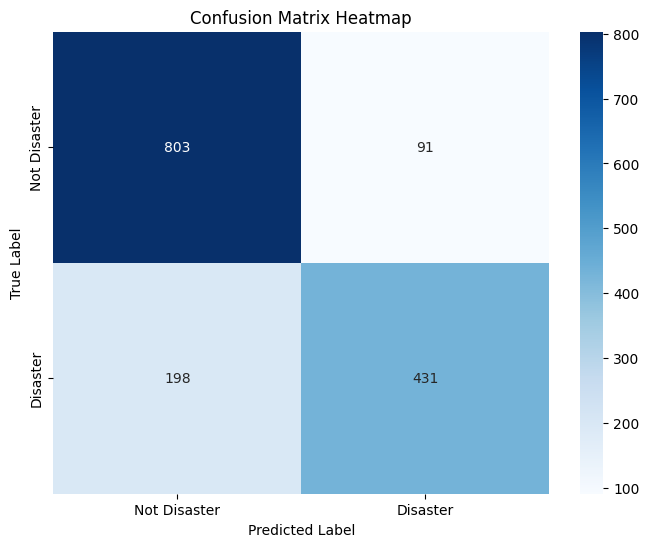

In [ ]:
# Confusion Matrix Heatmap
plt.figure(figsize=(8,6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Disaster', 'Disaster'],
            yticklabels=['Not Disaster', 'Disaster'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Heatmap')
plt.show()


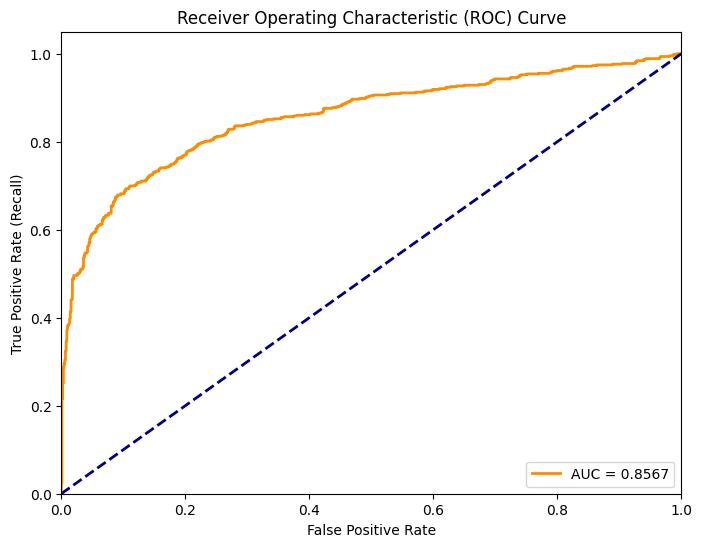

In [ ]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_true, y_probs)
roc_auc = roc_auc_score(y_true, y_probs)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}', color='darkorange', lw=2)
plt.plot([0,1], [0,1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


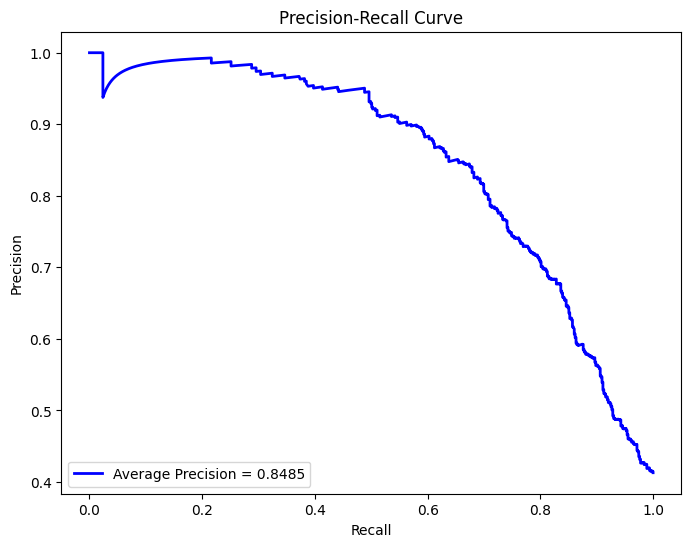

In [ ]:
# Precision-Recall Curve
precision_vals, recall_vals, thresholds = precision_recall_curve(y_true, y_probs)
avg_precision = average_precision_score(y_true, y_probs)

plt.figure(figsize=(8,6))
plt.plot(recall_vals, precision_vals, label=f'Average Precision = {avg_precision:.4f}', color='blue', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()


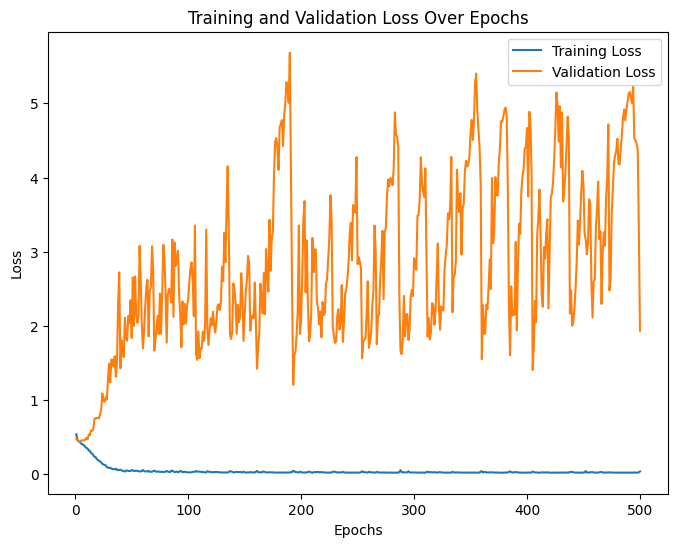

In [ ]:
# Training and Validation Loss Curves
plt.figure(figsize=(8,6))
plt.plot(range(1, epochs+1), train_losses_epoch, label='Training Loss')
plt.plot(range(1, epochs+1), val_losses_epoch, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()


In [ ]:
# Create DataLoader for test set
test_data = TensorDataset(torch.from_numpy(test_padded))
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Initialize hidden state
net.eval()
test_preds = []
with torch.no_grad():
    for inputs in test_loader:
        inputs = inputs[0]
        if train_on_gpu:
            inputs = inputs.cuda()
        else:
            inputs = inputs

        h = net.init_hidden(inputs.size(0), train_on_gpu)
        h = tuple([each.data for each in h])

        outputs, h = net(inputs, h)

        preds = torch.round(outputs.squeeze())
        test_preds.extend(preds.detach().cpu().numpy())

# Ensure the number of predictions matches test set size
test_preds = test_preds[:len(test)]


In [ ]:
# Save weights_matrix to a file
np.save('weights_matrix.npy', weights_matrix.numpy())


In [ ]:
%%writefile app.py
import streamlit as st
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import re
import pickle

# Load word2idx
with open('word2idx.pkl', 'rb') as f:
    word2idx = pickle.load(f)

# Clean text function
def clean_text(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"
                               u"\U0001F300-\U0001F5FF"
                               u"\U0001F680-\U0001F6FF"
                               u"\U0001F1E0-\U0001F1FF"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)

    url = re.compile(r'https?://\S+|www\.\S+')
    text = url.sub(r'', text)

    text = text.replace('#', ' ')
    text = text.replace('@', ' ')

    symbols = re.compile(r'[^A-Za-z0-9 ]')
    text = symbols.sub(r'', text)

    text = text.lower()

    return text

# Text to sequence function
def text_to_sequence(text, word2idx, maxlen=55):
    words = text.split()
    seq = [word2idx.get(word, 0) for word in words]
    if len(seq) > maxlen:
        seq = seq[:maxlen]
    else:
        seq = [0]*(maxlen - len(seq)) + seq
    return np.array(seq)

# Define the BiLSTM class
class BiLSTM(nn.Module):
    def __init__(self, weights_matrix, output_size, hidden_dim, hidden_dim2, n_layers, drop_prob=0.5):
        super(BiLSTM, self).__init__()

        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim

        # Embedding layer
        num_embeddings, embedding_dim = weights_matrix.size()
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        self.embedding.weight.data.copy_(weights_matrix)
        self.embedding.weight.requires_grad = False  # Freeze embedding layer

        # BiLSTM layer
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=drop_prob, bidirectional=True, batch_first=True)

        # Dropout layer
        self.dropout = nn.Dropout(0.3)

        # Fully connected layers
        self.fc1 = nn.Linear(hidden_dim * 2, hidden_dim2)
        self.fc2 = nn.Linear(hidden_dim2, output_size)

        # Activation function
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, hidden):
        batch_size = x.size(0)

        # Embedding
        embeds = self.embedding(x)

        # LSTM
        lstm_out, hidden = self.lstm(embeds, hidden)

        # Stack up LSTM outputs
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim * 2)

        # Dropout and fully connected layers
        out = self.dropout(lstm_out)
        out = self.fc1(out)
        out = F.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)

        # Sigmoid activation
        sig_out = self.sigmoid(out)

        # Reshape to batch_size first
        sig_out = sig_out.view(batch_size, -1)
        sig_out = sig_out[:, -1]  # Get last batch of labels

        return sig_out, hidden

    def init_hidden(self, batch_size, train_on_gpu=False):
        weight = next(self.parameters()).data

        layers = self.n_layers * 2  # Multiply by 2 for bidirectionality
        if train_on_gpu:
            hidden = (weight.new(layers, batch_size, self.hidden_dim).zero_().cuda(),
                      weight.new(layers, batch_size, self.hidden_dim).zero_().cuda())
        else:
            hidden = (weight.new(layers, batch_size, self.hidden_dim).zero_(),
                      weight.new(layers, batch_size, self.hidden_dim).zero_())
        return hidden

# Load the embedding weights matrix
weights_matrix = torch.tensor(np.load('weights_matrix.npy'))

# Instantiate the model
output_size = 1
hidden_dim = 128
hidden_dim2 = 64
n_layers = 2

net = BiLSTM(weights_matrix, output_size, hidden_dim, hidden_dim2, n_layers)

# Load the model's state_dict
net.load_state_dict(torch.load('state_dict.pt', map_location=torch.device('cpu')))
net.eval()

# Streamlit app
def main():
    st.title("Disaster Tweet Classifier")
    st.write("Enter a tweet to classify whether it's about a real disaster or not.")

    user_input = st.text_area("Enter Tweet Text:")

    if st.button("Classify"):
        if user_input:
            # Preprocess input
            clean_input = clean_text(user_input)
            seq = text_to_sequence(clean_input, word2idx)
            input_tensor = torch.from_numpy(seq).unsqueeze(0).type(torch.LongTensor)

            # Initialize hidden state
            h = net.init_hidden(1, train_on_gpu=False)
            h = tuple([each.data for each in h])

            # Make prediction
            with torch.no_grad():
                output, h = net(input_tensor, h)
                prob = output.item()
                pred = int(torch.round(output).item())

            # Display result
            if pred == 1:
                st.success(f"This tweet is about a **real disaster**. (Probability: {prob:.4f})")
            else:
                st.info(f"This tweet is **not about a real disaster**. (Probability: {prob:.4f})")
        else:
            st.warning("Please enter some text to classify.")

if __name__ == '__main__':
    main()


Writing app.py


In [ ]:
pip install streamlit pyngrok


In [ ]:
# Install necessary packages

# Authenticate ngrok
from pyngrok import ngrok
ngrok.set_auth_token('2mdzC5PhaSZt0Kh7DcRfqbT4pfK_366JmJjiSDP9qLC8ZrTSH')  # Replace with your actual token


In [ ]:
# Run the Streamlit app
import subprocess
import threading

def run_app():
    subprocess.call(['streamlit', 'run', 'app.py', '--server.port', '8501', '--server.headless', 'true'])

thread = threading.Thread(target=run_app)
thread.start()

# Expose the app using ngrok
public_url = ngrok.connect(8501)
print(f'Access your app at: {public_url}')


Access your app at: NgrokTunnel: "https://cfe5-34-82-129-198.ngrok-free.app" -> "http://localhost:8501"


In [ ]:
!python --version

Python 3.10.12


In [ ]:
import torch
print(torch.__version__)

2.4.1+cu121
